<a href="https://colab.research.google.com/github/fuerdagegen/retail-sales-forecasting/blob/main/model_prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

This notebook uses Prophet to model aggregated daily demand in Guayas.  
Prophet expects a two-column input format (`ds` for datestamps and `y` for the target), so the cleaned dataset is aggregated to daily totals before training.

In [ ]:
# Install Prophet in the Colab environment
!pip install prophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 147.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 101.1 MB/s eta 0:00:00


In [ ]:
# Core libraries
import numpy as np
import pandas as pd
import warnings
import time

# Plotting
from matplotlib import pyplot as plt
import seaborn as sns

# Model and evaluation
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Google Drive integration
from google.colab import drive

warnings.filterwarnings('ignore')  # keep notebook output focused

# Loading data

The cleaned dataset from the data preparation notebook is loaded from Drive.  
Sales are then aggregated to a single daily series and reshaped into Prophet’s required `ds` / `y` format.

In [ ]:
# Load the cleaned dataset from Drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/retail-sales-forecasting/df_train_sample.csv')

Mounted at /content/drive


In [ ]:
# Ensure date is parsed correctly for time-series operations
df['date'] = pd.to_datetime(df['date'])

# Aggregate to a single daily series (sum across all stores and items)
daily_sales = df.groupby('date')['unit_sales'].sum().reset_index()

# Prophet expects columns named 'ds' (date) and 'y' (target)
prophet_df = daily_sales.rename(columns={'date': 'ds', 'unit_sales': 'y'})

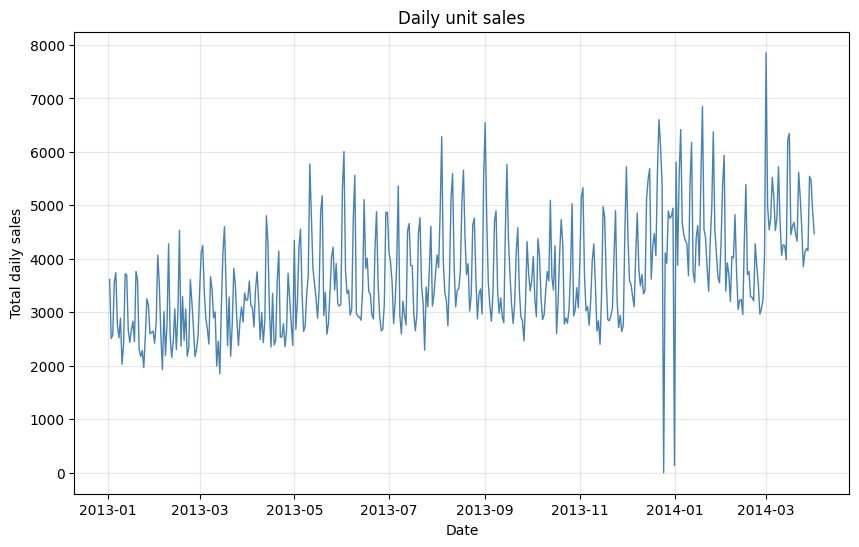

In [ ]:
# Visual check of the aggregated daily series
plt.figure(figsize=(10, 6))
plt.plot(prophet_df['ds'], prophet_df['y'], color='steelblue', linewidth=1)
plt.title('Daily unit sales')
plt.xlabel('Date')
plt.ylabel('Total daily sales')
plt.grid(True, alpha=0.3)
plt.show()

# Prophet model

This section splits the aggregated daily sales series into training and testing periods, fits a Prophet model with weekly and yearly seasonality, and evaluates forecast performance over the January–March 2014 horizon.

In [ ]:
# Split data into training and test periods
split_date = '2014-01-01'
train_df = prophet_df[prophet_df['ds'] < split_date].copy()
test_df = prophet_df[
    (prophet_df['ds'] >= split_date) &
    (prophet_df['ds'] <= '2014-03-31')
].copy()

print(f"Training set: {len(train_df)} days ({train_df['ds'].min()} to {train_df['ds'].max()})")
print(f"Test set: {len(test_df)} days ({test_df['ds'].min()} to {test_df['ds'].max()})")

Training set: 364 days (2013-01-02 00:00:00 to 2013-12-31 00:00:00)
Test set: 90 days (2014-01-01 00:00:00 to 2014-03-31 00:00:00)


In [ ]:
# Initialize Prophet model with weekly and yearly seasonality
model = Prophet(
    daily_seasonality=False,      # daily seasonality not needed for daily data
    weekly_seasonality=True,      # capture weekday patterns
    yearly_seasonality=True,      # capture annual seasonality
    seasonality_mode='additive',  # seasonal effects add to the trend
    changepoint_prior_scale=0.05  # default trend flexibility
)

In [ ]:
# Fit the model on the training data
model.fit(train_df)

# Create future dataframe covering the test horizon
future = model.make_future_dataframe(periods=len(test_df), freq='D')

# Generate forecast
forecast = model.predict(future)

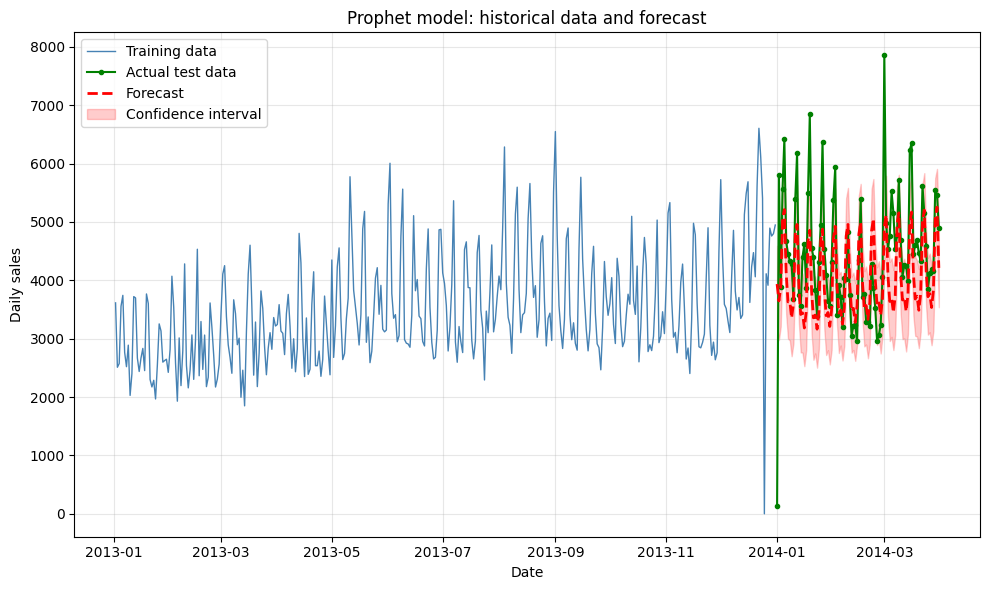

In [ ]:
plt.figure(figsize=(10, 6))

# Training data
plt.plot(train_df['ds'], train_df['y'],
         color='steelblue', linewidth=1, label='Training data')

# Actual test data
plt.plot(test_df['ds'], test_df['y'],
         color='green', linewidth=1.5, label='Actual test data',
         marker='o', markersize=3)

# Forecast for the test period
test_forecast = forecast[
    (forecast['ds'] >= split_date) &
    (forecast['ds'] <= '2014-03-31')
].copy()

plt.plot(test_forecast['ds'], test_forecast['yhat'],
         color='red', linewidth=2, linestyle='--', label='Forecast')

# Confidence interval
plt.fill_between(
    test_forecast['ds'],
    test_forecast['yhat_lower'],
    test_forecast['yhat_upper'],
    color='red', alpha=0.2, label='Confidence interval'
)

plt.title('Prophet model: historical data and forecast')
plt.xlabel('Date')
plt.ylabel('Daily sales')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Extract predictions for the test period
test_predictions = forecast[forecast['ds'].isin(test_df['ds'])].copy()
test_predictions = test_predictions.merge(test_df, on='ds', how='left')

y_true = test_predictions['y']
y_pred = test_predictions['yhat']

In [ ]:
# Compute evaluation metrics on the test set
mae = mean_absolute_error(y_true, y_pred)            # average absolute error
mse = mean_squared_error(y_true, y_pred)             # average squared error
rmse = np.sqrt(mse)                                  # error in original units

# R² computed manually from residuals
residuals = y_true - y_pred
r2 = 1 - (np.sum(residuals**2) / np.sum((y_true - y_true.mean())**2))  # 1 = perfect fit

print("Prophet model performance")
print(f"RMSE: {rmse:.6f}")
print(f"MAE:  {mae:.6f}")
print(f"MSE:  {mse:.6f}")
print(f"R²:   {r2:.4f}")

Prophet model performance
RMSE: 904.307900
MAE:  673.123236
MSE:  817772.777946
R²:   0.2742
